# Setup

In [1]:
import googlemaps
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests
from PIL import Image
import time
from tqdm import tqdm
import json
import geopy.distance
from itertools import chain

with open('apikey.txt') as file:
    API_KEY = file.read().strip()

google_calls = 0
prev_lookups = {}

In [2]:
gmaps = googlemaps.Client(key=API_KEY)

with open('stoplocations.json') as file:
    bus_stop_locations = json.load(file)
with open("stoplookup.json") as file:
    stop_lookup = json.load(file)
with open('stopschedule.json') as file:
    stopschedule = json.load(file)
with open('stopnames.json') as file:
    stop_names = json.load(file)
with open('stoptimes.json') as file:
    stoptimes = json.load(file)




# stopschedule = {}
# for line, v in stopschedule_.items():
#     tmp1 = {}
#     for day in ['Aug 22', 'Aug 23', 'Aug 24', 'Aug 25', 'Aug 26']:
#         for tripid, v2 in v.get(day, {}).items():
#             tmp2 = {}
#             for stop, time in v2:
#                 tmp2[stop] = time
#             tmp1[tripid] = tmp2
#     stopschedule[line] = tmp1
    

In [16]:
def plot(lat,lon,c):
    A = np.array([[ 3.30048468e+00, -1.76873312e+03],
       [ 1.44506111e+03, -7.69612341e+00],
       [ 1.54147586e+05,  6.14923771e+04]]).T
    pltx = A[1]@[lat,lon,1]
    plty = A[0]@[lat,lon,1]
    plt.scatter([plty], [pltx], color=c)

def l1_geodesic(a,b):
    a = (a['lat'], a['lng'])
    b = (b['lat'], b['lng'])
    return geopy.distance.geodesic((a[0],a[1]), (a[0],b[1])).miles + geopy.distance.geodesic((a[0],b[1]), (b[0],b[1])).miles    


def l2_geodesic(a,b):
    a = (a['lat'], a['lng'])
    b = (b['lat'], b['lng'])
    return geopy.distance.geodesic(a,b).miles


def tripinfo(start, bus_start, bus_end, end):
    bike_dist = l1_geodesic(start, bus_stop_locations[bus_start])
    bus_dist = l1_geodesic(bus_stop_locations[bus_start], bus_stop_locations[bus_end])
    bike_dist2 = l1_geodesic(bus_stop_locations[bus_end], end)
    return bike_dist, bus_dist, bike_dist2

def time2float(time):
    hour, minute, second = list(map(int, time.split(':')))
    return hour + minute/60 + second/3600

def bike_distance(start, end):
    global prev_lookups
    tup = (start['lat'], start['lng'], end['lat'], end['lng'])
    if tup in prev_lookups:
        return prev_lookups[tup]
    global google_calls
    
    google_calls += 1
    
    d = gmaps.directions(start, end, mode='bicycling')[0]['legs'][0]
    distance = d['distance']['value'] / 1609
    duration = d['duration']['value'] / 60
    prev_lookups[tup] = (distance, duration)
    return (distance, duration)
    
class DistanceList:
    def __init__(self, peg1, peg2, trip_id, stops, bus_weight=5, prefilter=True):
        self.peg1 = peg1
        self.peg2 = peg2
        self.trip_id = trip_id
        self.bus_weight = bus_weight
        start_dists = [(s1, l2_geodesic(peg1, bus_stop_locations[s1])) for s1 in stops]
        end_dists = [(s2, l2_geodesic(bus_stop_locations[s2], peg2)) for s2 in stops]
        self.data = [ (s1, s2, d1, d1/0.2, d2, d2/0.2, bus_distance(trip_id, s1, s2), False) for i,(s1,d1) in enumerate(start_dists) for s2,d2 in end_dists[i+1:]]
        self.key = lambda x: x[2] + x[4] + x[6]/self.bus_weight
        
        if prefilter and len(self.data) > 10:
            old_len = len(self.data)
            self.data = [self.data[i] for i in np.argpartition([self.key(x) for x in self.data], min(10, old_len))[:min(old_len, 10)]]
#             print("data length reduced to ", len(self.data), " from ", old_len)
            
    def pop(self):
        i  = np.argmin([self.key(x) for x in self.data])
        while not self.data[i][-1]:
            sid1 = self.data[i][0]
            sid2 = self.data[i][1]
            self.data[i] = (sid1, sid2, *bike_distance(self.peg1, bus_stop_locations[sid1]), *bike_distance(bus_stop_locations[sid2], self.peg2), self.data[0][-2], True)
#             self.data = self.data[np.argpartition([self.key(x) for x in self.data], 0)]
            i  = np.argmin([self.key(x) for x in self.data])
        i  = np.argmin([self.key(x) for x in self.data])
        res = self.data.pop(i)
        return res[:-1]
    
def nearest_stops_on_trip(trip_id, stop_seq, start, end, timer=None):
    if timer is not None:
        timer.start('key creation')
        keys = sorted(list(stop_seq.keys()), key=lambda x: time2float(stop_seq[x]))
        timer.stop('key creation')
        timer.start('list creation')
    prelim_dists = DistanceList(start, end, trip_id, keys)
    if timer is not None:
        timer.stop('list creation')
        timer.start('pop')
    res= prelim_dists.pop() # bus_start, bus_end, start_dist, end_dist, bus_dist
    if timer is not None:
        timer.stop('pop')
    return res
    

def bus_distance(trip_id, start, end):
    return (stoptimes[trip_id][end] - stoptimes[trip_id][start]) / 1.609
#     trip = stoptimes[stoptimes['trip_id'] == trip_id]
#     start_dist = trip[trip['stop_id']==start]['shape_dist_traveled'].iloc[0]
#     end_dist = trip[trip['stop_id']==end]['shape_dist_traveled'].iloc[0]
#     if np.isnan(start_dist):
#         start_dist = 0
#     if np.isnan(end_dist):
#         end_dist = 0
#     return (end_dist - start_dist) / 1.609


In [4]:
from time import time as time_now
class Timer:
    def __init__(self):
        self.data = {}
    def start(self, key):
        self.data[key] =self.data.get(key, 0) - time_now()
    def stop(self, key):
        self.data[key] += time_now()
    def report(self):
        return
        for k, v in self.data.items():
            print(k, ': ', v)

In [5]:
#
# First, check how long the biking distance would be
# (do that)
def run(start_address, end_address, start_time, end_time):
# if True:
    # Next, find all stops within 3 miles of the start address, and all stops within 3 miles of the end address
    start_location = gmaps.geocode(start_address)[0]['geometry']['location']
    end_location = gmaps.geocode(end_address)[0]['geometry']['location']
    img = Image.open('abqmap2.png')
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    print(f"{start_address} in blue, {end_address} in red")
    plot(start_location['lat'], start_location['lng'], 'blue')
    plot(end_location['lat'], end_location['lng'], 'red')
    plt.show()
    stops_close_to_start = [ stop for stop, coord in bus_stop_locations.items() if l1_geodesic(coord, start_location) < 3 ]
    stops_close_to_end = [ stop for stop, coord in bus_stop_locations.items() if l1_geodesic(coord, end_location) < 3 ]

    lines_close_to_start = {}
    for stop in stops_close_to_start:
        for line in stop_lookup[stop]:
            if line not in lines_close_to_start:
                lines_close_to_start[line] = set()
            lines_close_to_start[line].add(stop)


    lines_close_to_end = {}
    for stop in stops_close_to_end:
        for line in stop_lookup[stop]:
            if line not in lines_close_to_end:
                lines_close_to_end[line] = set()
            lines_close_to_end[line].add(stop)

    shared_lines = [k for k in lines_close_to_end if k in lines_close_to_start]        
    bus_routes = {}
    trips_wtimes = []
    prev_calcs = {}

    print("Checking nearby bus lines...")
    for line in tqdm(shared_lines):
        all_trips = stopschedule[str(line)]
        seen_trips = set()
        timer = Timer()
        for trip_id, stop_seq in all_trips.items():
            timer.start('initial check')
            if min(map(time2float, stop_seq.values())) > end_time or max(map(time2float, stop_seq.values())) < start_time:
                timer.stop('initial check')
                continue
            timer.stop('initial check')
            timer.start('tuple creation')
            tup = tuple(sorted(stop_seq.keys())) 
            timer.stop('tuple creation')
            timer.start('prev calcs lookup')
            if tup in prev_calcs:
                timer.stop('prev calcs lookup')
                timer.start('prev calcs fetch')
                bus_start,  bus_end,  start_dist,bike_time_start, end_dist, bike_time_end, bus_dist = prev_calcs[tup]
                timer.stop('prev calcs fetch')
            else:
                timer.stop('prev calcs lookup')
                timer.start('nearest stops calc')
                bus_start,  bus_end,  start_dist,bike_time_start, end_dist, bike_time_end, bus_dist = nearest_stops_on_trip(trip_id, stop_seq, start_location, end_location, timer=timer)
                timer.stop('nearest stops calc')
                timer.start('prev calcs store')
                prev_calcs[tup] = bus_start,  bus_end,  start_dist,bike_time_start, end_dist, bike_time_end, bus_dist
                timer.stop('prev calcs store')
            timer.start('the rest')
            time_start = time2float(stop_seq[bus_start])
            time_end = time2float(stop_seq[bus_end])
            if time_start > time_end:
                timer.stop('the rest')
                continue
            if time_start >= start_time and time_start < end_time and (time_start, time_end) not in seen_trips:
                seen_trips.add((time_start, time_end))
                trips_wtimes.append({'line': line, 'bike_time1': bike_time_start, 'bike_time2': bike_time_end, 'bike1': start_dist, 'bike2': end_dist, 'bus_dist': bus_distance(trip_id, bus_start, bus_end), \
                                'bus_start': bus_start, 'bus_end': bus_end, 'time_start': stop_seq[bus_start], 'time_end': stop_seq[bus_end], 'bus_duration': time_end - time_start})
            timer.stop('the rest')
        timer.report()
        if len(seen_trips) == 0:
            print("No easy bus trips found")
    bike_only, bike_only_time = bike_distance(start_location, end_location)
    print(f"Travel from {start_address} to {end_address}")
    print()
    print(f"Bike directly: {round(bike_only, 3)} miles, ~{round(bike_only_time,2)} minutes")
    print()
    for tinfo in sorted(trips_wtimes, key=lambda x: time2float(x['time_start'])):
        if tinfo['bike1'] + tinfo['bike2'] > bike_only *2/3:
#             continue
            pass
        print(f"Take bus #{tinfo['line']}")
        print(f"\tBike {round(tinfo['bike1'],3)} miles to {stop_names[tinfo['bus_start']]} (~{round(tinfo['bike_time1'],2)} minutes)")
        print(f"\tBus at {tinfo['time_start']} for {round(tinfo['bus_dist'],3)} miles to {stop_names[tinfo['bus_end']]} at {tinfo['time_end']}")
        print(f"\tBike {round(tinfo['bike2'],3)} miles (~{round(tinfo['bike_time1'],2)} minutes)")
        print(f"Total biking: {round(tinfo['bike1'] + tinfo['bike2'], 3)} miles, ~{round(tinfo['bike_time1'] + tinfo['bike_time2'], 2)} minutes")
        print(f"Total distance: {round(tinfo['bike1']+tinfo['bike2']+tinfo['bus_dist'],3)}, ~{round(tinfo['bike_time1'] + tinfo['bike_time2'] + 60*(time2float(tinfo['time_end']) - time2float(tinfo['time_start'])))} minutes")
        print()                
#     return trips_wtimes

# Script

Broadway Blvd SE and Avenida Cesar Chavez, Albuquerque, New Mexico in blue, 20th St SE and K St SE, Albuquerque, New Mexico in red


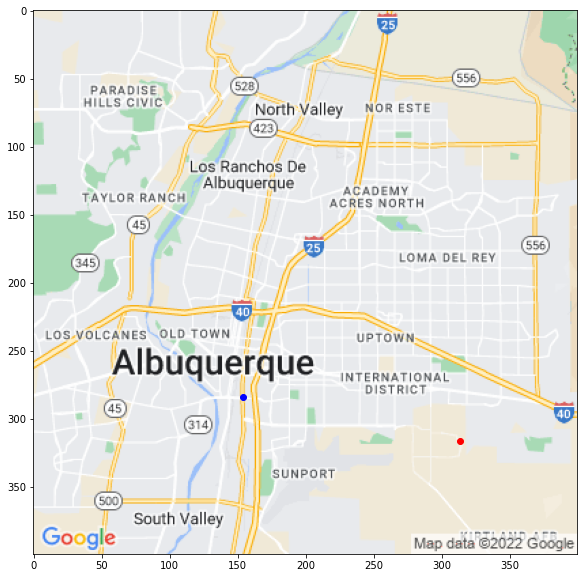

Checking nearby bus lines...


  0%|                                                                                           | 0/8 [00:00<?, ?it/s]

No easy bus trips found
No easy bus trips found


 50%|█████████████████████████████████████████▌                                         | 4/8 [00:04<00:05,  1.33s/it]

No easy bus trips found


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:10<00:00,  1.28s/it]

Travel from Broadway Blvd SE and Avenida Cesar Chavez, Albuquerque, New Mexico to 20th St SE and K St SE, Albuquerque, New Mexico

Bike directly: 8.469 miles, ~50.17 minutes

Take bus #11
	Bike 1.31 miles to A.T.C.  (Bay D) (~7.33 minutes)
	Bus at 13:01:00 for 7.32 miles to Lomas @ Eubank at 13:31:44
	Bike 2.917 miles (~7.33 minutes)
Total biking: 4.226 miles, ~23.47 minutes
Total distance: 11.546, ~54 minutes

Take bus #66
	Bike 3.847 miles to Central @ Monroe (~27.48 minutes)
	Bus at 13:02:30 for 0.174 miles to Central @ Adams at 13:03:32
	Bike 5.328 miles (~27.48 minutes)
Total biking: 9.175 miles, ~57.27 minutes
Total distance: 9.348, ~58 minutes

Take bus #66
	Bike 1.117 miles to Central @ Edith (~6.82 minutes)
	Bus at 13:05:07 for 6.113 miles to Central @ Eubank at 13:39:00
	Bike 1.884 miles (~6.82 minutes)
Total biking: 3.002 miles, ~16.22 minutes
Total distance: 9.115, ~50 minutes

Take bus #97
	Bike 0.717 miles to Coal @ Broadway (~3.53 minutes)
	Bus at 13:07:25 for 5.819 mile

In [20]:
# For going to work, should only need to change the "start_address"
# Put either your address or your nearest cross-streets
start_address = "Broadway Blvd SE and Avenida Cesar Chavez, Albuquerque, New Mexico"
# start_address = "Alvarado Transportation Center, Albuquerque, New Mexico"
end_address = "20th St SE and K St SE, Albuquerque, New Mexico"

# Put the time-range you would like to leave in the morning, 0-24
window_start = 13
window_end = 15

# Press Shift+Enter to run
# A map of Albuquerque will show up; if the blue and red dots are not
# in the right places, try using a different address
run(start_address, end_address, window_start, window_end)
# Results will be below the map

20th St SE and K St SE, Albuquerque, New Mexico in blue, Broadway Blvd SE and Avenida Cesar Chavez, Albuquerque, New Mexico in red


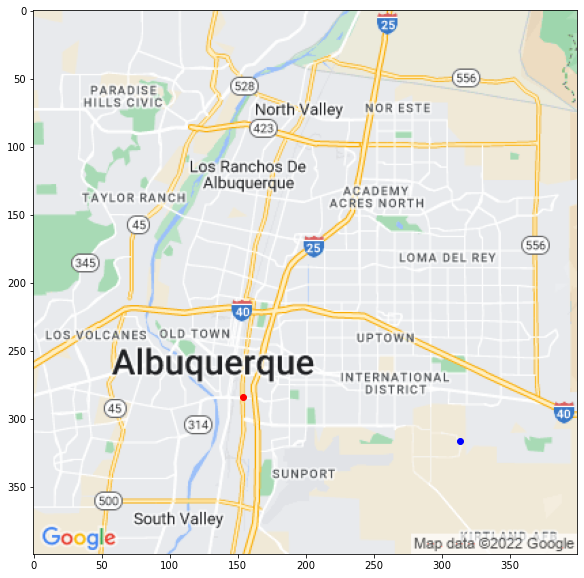

Checking nearby bus lines...


 12%|██████████▍                                                                        | 1/8 [00:02<00:19,  2.78s/it]

No easy bus trips found
No easy bus trips found
No easy bus trips found
No easy bus trips found
No easy bus trips found
No easy bus trips found


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.01s/it]

Travel from 20th St SE and K St SE, Albuquerque, New Mexico to Broadway Blvd SE and Avenida Cesar Chavez, Albuquerque, New Mexico

Bike directly: 8.141 miles, ~37.02 minutes

Take bus #66
	Bike 6.133 miles to Central @ Hermosa (~28.67 minutes)
	Bus at 21:01:00 for 0.14 miles to Central @ Aliso at 21:01:46
	Bike 3.275 miles (~28.67 minutes)
Total biking: 9.408 miles, ~45.25 minutes
Total distance: 9.549, ~46 minutes

Take bus #777
	Bike 6.415 miles to ART - Nob Hill Station (~29.52 minutes)
	Bus at 21:08:00 for 0.422 miles to ART - Nob Hill East Station at 21:09:38
	Bike 3.247 miles (~29.52 minutes)
Total biking: 9.663 miles, ~45.62 minutes
Total distance: 10.084, ~47 minutes

Take bus #66
	Bike 1.662 miles to Central @ Eubank (~8.88 minutes)
	Bus at 21:20:00 for 6.187 miles to Central @ High at 21:48:42
	Bike 1.19 miles (~8.88 minutes)
Total biking: 2.851 miles, ~16.17 minutes
Total distance: 9.039, ~45 minutes

Take bus #66
	Bike 6.133 miles to Central @ Hermosa (~28.67 minutes)
	Bus 

In [21]:
# For returning from work, should only need to change the "end_address"
# Put either your address or your nearest cross-streets
# start_address = "Thunderbird Cafe, Albuquerque, New Mexico"
# end_address = "Comanche and Juan Tabo, Albuquerque, New Mexico"


# Put the time-range you would like to leave in the evening, 0-24
window_start = 21
window_end = 23

# Press Shift+Enter to run
# A map of Albuquerque will show up; if the blue and red dots are not
# in the right places, try using a different address
run(end_address, start_address, window_start, window_end)
# Results will be below the map